In [10]:
import itertools
from dataclasses import asdict, dataclass
from functools import partial
from typing import Any
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from common import EXPORT_DPI, OUTPUT_DIR, PAPER_WIDTH_IN, setup_plotting
from jk_utils import (
    construct_vandermonde,
    trigonometric_polynomial_centered,
)
from scipy.integrate import solve_ivp, trapezoid

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
setup_plotting()

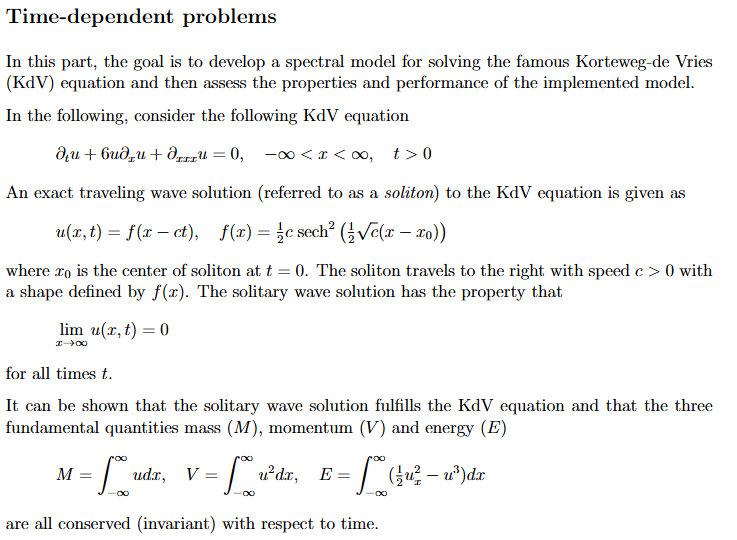

# 2.c
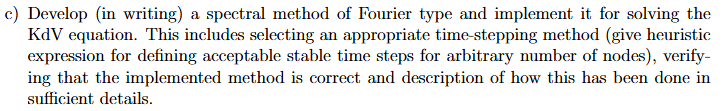

Heuristic: 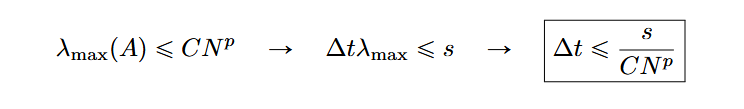

t=0.000, error=0.00e+00
t=0.333, error=6.51e-04
t=0.667, error=6.78e-04
t=1.000, error=3.29e-04
t=1.333, error=7.86e-04
t=1.667, error=1.67e-03
t=2.000, error=2.50e-03
t=2.333, error=3.13e-03
t=2.667, error=3.53e-03
t=3.000, error=3.64e-03


c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


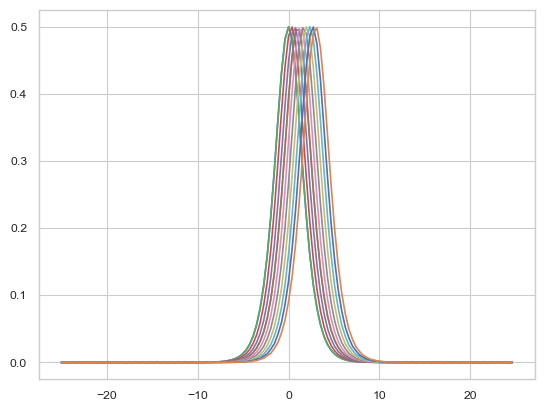

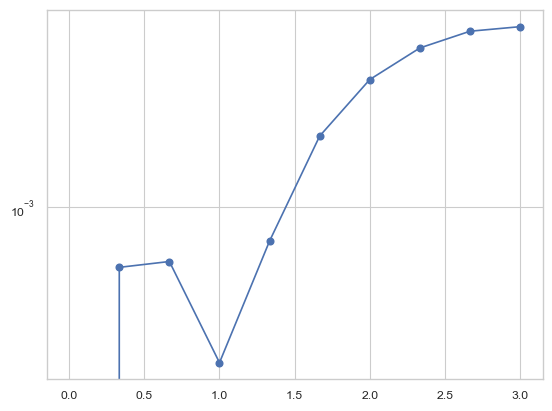

In [12]:
# Domain
a = -25.0
b = -a
L = b - a

# Discretisation
N_grid = 128
N = N_grid - 1  # Polynomial degree

# Problem parameters
c = 1.0  # Wave speed, c > 0
x_0 = 0.0  # Initial position of the soliton

# Basis functions
basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)

# Set up nodes
x = np.linspace(
    a, b, N_grid, endpoint=False
)  # No last point since we impose periodicity


def travelling_soliton(
    x: npt.NDArray[np.float64], t: float, c: float, x_0: float
) -> npt.NDArray[np.float64]:
    x_prime = x - c * t

    sech_argument = np.sqrt(c) * (x_prime - x_0) / 2.0
    f = 1 / 2 * c * (1 / np.cosh(sech_argument)) ** 2

    return f


plt.figure()
plt.plot(x, travelling_soliton(x, t=0.0, c=c, x_0=x_0), label="t=0")

# Set up differentiation matrix
V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve
D3 = D @ D @ D

# Set up initial condition
u_0 = travelling_soliton(x, t=0.0, c=c, x_0=x_0).astype(np.complex128)

# Simulation time
t_0 = 0.0
t_final = 3.0
N_eval = 10
t_eval = np.linspace(t_0, t_final, N_eval, endpoint=True)


# Set up differential equation operator
def eval_timestep(
    t: float, u: npt.NDArray[np.complex128]
) -> npt.NDArray[np.complex128]:
    """Evaluate the time derivative du/dt at time t and state u."""
    u_x = D @ u
    uu_x = u * u_x
    u_xxx = D3 @ u
    return -6 * uu_x - u_xxx


solve_result = solve_ivp(
    eval_timestep, (t_0, t_final), u_0, method="RK45", t_eval=t_eval
)

plt.plot(x, np.real(solve_result.y[:, 3]))

for t, u in zip(solve_result.t, solve_result.y.T):
    plt.plot(x, u.T, label=f"t={t:.3f}")

# Compare errors
data = []
for t, u_numeric in zip(solve_result.t, solve_result.y.T):
    u_exact = travelling_soliton(x, t, c=c, x_0=x_0)
    error = np.linalg.norm(u_exact - np.real(u_numeric), ord=2)
    relative_error = error / np.linalg.norm(u_exact, ord=2)
    data.append(
        {
            "t": t,
            "error": error,
            "relative_error": relative_error,
        }
    )
    print(f"t={t:.3f}, error={error:.2e}")

df = pd.DataFrame(data)
plt.figure()
plt.semilogy(df["t"], df["error"], "-o", label="L2 Error")

In [13]:
# See IVP slide 40

s = 2.7853  # eq 2.159 in https://leifh.folk.ntnu.no/teaching/tkt4140/._main025.html#:~:text=By%20substitution%20of%20%CE%BBx,as%20illstrated%20in%20figure%2023.

# Method: RK45
p = 3  # From cell below
C = 3e-4  # From cell below


def max_timestep(N: int) -> float:
    """Estimate the maximum stable timestep for an explicit method."""
    return s / (C * N**p)

In [14]:
# Conserved Quantities
def mass(u: npt.NDArray[np.complex128], x: npt.NDArray[np.float64]) -> float:
    """
    Compute the mass of $u$ over the domain.

    Arguments:
        u: The function values at the grid points.
        x: The spatial grid points.

    Returns:
        The mass of $u$ over the domain.
    """
    return trapezoid(u, x)


def momentum(u: npt.NDArray[np.complex128], x: npt.NDArray[np.float64]) -> float:
    """
    Compute the momentum of $u$ over the domain.

    Arguments:
        u: The function values at the grid points.
        x: The spatial grid points.

    Returns:
        The momentum of $u$ over the domain.
    """
    return trapezoid(u**2, x)


def energy(
    u: npt.NDArray[np.complex128],
    x: npt.NDArray[np.float64],
    D: npt.NDArray[np.complex128],
) -> float:
    """
    Compute the energy of $u$ over the domain.

    Arguments:
        u: The function values at the grid points.
        x: The spatial grid points.
        D: The differentiation matrix.

    Returns:
        The energy of $u$ over the domain.
    """
    u_x = D @ u
    integrand = 1 / 2 * u_x**2 - u**3
    return np.real(trapezoid(integrand, x))


In [15]:
@dataclass(slots=True, frozen=True)
class SingleSolitonSimulationResult:
    # Simulation Parameters
    N_grid: int  # Number of grid points
    N: int  # Polynomial degree
    dx: float  # Grid spacing

    a: float  # Domain left boundary
    b: float  # Domain right boundary
    L: float  # Domain length

    t_0: float  # Initial time
    t_final: float  # Final time

    t_max_step: float  # Maximum stable timestep, heuristic estimate

    # Problem Parameters
    c: float  # Wave speed
    x_0: float  # Initial position of the soliton

    # Simulation Results
    t: npt.NDArray[np.float64]
    x: npt.NDArray[np.float64]
    u: npt.NDArray[np.float64]
    u_exact: npt.NDArray[np.float64]
    u_final_numeric: npt.NDArray[np.float64]
    u_final_exact: npt.NDArray[np.float64]

    solve_result: Any

    total_time_wall: float
    total_time_cpu: float

    solve_time_wall: float
    solve_time_cpu: float
    solve_time_per_step_wall: float
    solve_time_per_step_cpu: float

    solve_nfev: int  # Number of function evaluations for solver

    # Errors
    error_L2: float
    relative_error_L2: float
    error_L_inf: float
    relative_error_L_inf: float

    # Heuristics
    max_eig_magnitude: float

    # Conserved quantities
    masses: npt.NDArray[np.float64]
    momenta: npt.NDArray[np.float64]
    energies: npt.NDArray[np.float64]


def single_soliton_simulation(
    a: float,
    b: float,
    N_grid: int,
    c: float,
    x_0: float,
    t_0: float,
    t_final: float,
    use_orszag_23_rule: bool = False,
) -> SingleSolitonSimulationResult:
    """
    Simulate the KdV equation for a single travelling soliton.
    """
    total_start_time_wall = time.perf_counter()
    total_start_time_cpu = time.process_time()
    N = N_grid - 1  # Polynomial degree
    L = b - a  # Domain size

    # Basis functions
    basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
    basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)

    # Set up nodes
    # No last point since we impose periodicity through basis functions
    x = np.linspace(a, b, N_grid, endpoint=False)
    dx = x[1] - x[0]

    # Set up differentiation matrix
    V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
    V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
    D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve
    D3 = D @ D @ D

    # Set up initial condition
    u_0 = travelling_soliton(x, t=t_0, c=c, x_0=x_0).astype(np.complex128)

    # In order to do heuristic stability analysis we require a matrix representation of our operator,
    # which in turn requires us to linearize the operator, ideally in a conservative manner
    # Conservative comes from the fact that we pick the maximal value of u_0 as a
    # 'worst case' estimate of the non-linear term.
    u_0_max = np.max(np.abs(u_0))
    L_N_linear = -6 * u_0_max * D - D3

    # Compute eigenvalues for stability analysis
    eigvals_linear_estimate = np.linalg.eigvals(L_N_linear)
    max_eig_magnitude = np.max(np.abs(eigvals_linear_estimate))
    # Using these eigenvalues we can do heuristic from slide 40 of IVP lecture
    # Note that this is somewhat circular here,
    # since I have already done this analysis and implemented the max_timestep function above
    # The derivation of max_timestep(N) is explained below and if any parameters change
    # (discretisation, timestepping algorithm), then the function above should be adjusted
    # by referring to the analysis below this cell

    # Set up differential equation operator
    @numba.jit(nopython=True, parallel=True)
    def eval_timestep(
        t: float, u: npt.NDArray[np.complex128]
    ) -> npt.NDArray[np.complex128]:
        if use_orszag_23_rule:
            # 2/3 rule is a way to reduce aliasing errors at the cost of resolution
            # Note that this part of the function will be JIT compiled,
            # so no need to worry about performance here or precomputation outside the function
            orszag_23_cutoff_start = int(np.floor(N_grid / 3))
            orszag_23_cutoff_end = int(np.ceil(2 * N_grid / 3))

            # In default fft frequencies are ordered as zero, positive increasing, negative decreasing
            # As such, the high frequency modes are at center of the array
            # See: https://numpy.org/devdocs/reference/routines.fft.html#implementation-details
            orszag_23_filter = np.ones(N_grid, dtype=np.complex128)
            orszag_23_filter[orszag_23_cutoff_start:orszag_23_cutoff_end] = 0

            # Apply 23 rule in spectral space
            u_hat = np.fft.fft(u)
            u_hat_filtered = u_hat * orszag_23_filter
            u_filtered = np.fft.ifft(u_hat_filtered)
            u_x = D @ u_filtered
        else:
            u_x = D @ u

        uu_x = u * u_x
        u_xxx = D3 @ u

        return -6 * uu_x - u_xxx

    # Compute eval_timestep once to trigger JIT compilation before timing
    _ = eval_timestep(t_0, u_0)

    t_max_step = max_timestep(N)
    solve_start_time_wall = time.perf_counter()
    solve_start_time_cpu = time.process_time()
    solve_result = solve_ivp(
        eval_timestep, (t_0, t_final), u_0, method="RK45", max_step=t_max_step
    )
    solve_end_time_wall = time.perf_counter()
    solve_end_time_cpu = time.process_time()

    u_numeric = np.real(solve_result.y)
    u_exact = np.zeros_like(u_numeric)
    for i, t in enumerate(solve_result.t):
        u_exact[:, i] = travelling_soliton(x, t, c=c, x_0=x_0)

    # Compute error
    u_final_numeric = u_numeric[:, -1]
    u_final_exact = travelling_soliton(x, t_final, c=c, x_0=x_0)
    error_L2 = np.linalg.norm(u_final_exact - u_final_numeric, ord=2)
    relative_error_L2 = error_L2 / np.linalg.norm(u_final_exact, ord=2)
    error_L_inf = np.linalg.norm(u_final_exact - u_final_numeric, ord=np.inf)
    relative_error_L_inf = error_L_inf / np.linalg.norm(u_final_exact, ord=np.inf)

    # Compute conserved quantities over time
    masses = np.asarray([mass(u, x) for u in u_numeric.T])
    momenta = np.asarray([momentum(u, x) for u in u_numeric.T])
    energies = np.asarray([energy(u, x, D) for u in u_numeric.T])

    total_end_time_wall = time.perf_counter()
    total_end_time_cpu = time.process_time()

    return SingleSolitonSimulationResult(
        N_grid=N_grid,
        N=N,
        dx=dx,
        a=a,
        b=b,
        L=L,
        t_0=t_0,
        t_final=t_final,
        t_max_step=t_max_step,
        c=c,
        x_0=x_0,
        t=solve_result.t,
        x=x,
        u=u_numeric,
        u_exact=u_exact,
        u_final_numeric=u_final_numeric,
        u_final_exact=u_final_exact,
        solve_result=solve_result,
        error_L2=error_L2,
        relative_error_L2=relative_error_L2,
        error_L_inf=error_L_inf,
        relative_error_L_inf=relative_error_L_inf,
        max_eig_magnitude=max_eig_magnitude,
        total_time_wall=total_end_time_wall - total_start_time_wall,
        total_time_cpu=total_end_time_cpu - total_start_time_cpu,
        solve_time_wall=solve_end_time_wall - solve_start_time_wall,
        solve_time_cpu=solve_end_time_cpu - solve_start_time_cpu,
        solve_time_per_step_wall=(solve_end_time_wall - solve_start_time_wall) / solve_result.nfev,
        solve_time_per_step_cpu=(solve_end_time_cpu - solve_start_time_cpu) / solve_result.nfev,
        solve_nfev=solve_result.nfev,
        masses=masses,
        momenta=momenta,
        energies=energies,
    )


In [29]:
# Simulation parameters
t_0 = 0.0
t_final = 3.0

a = -30.0
b = -a

# Problem parameters
c = 1.0  # Wave speed, c > 0
x_0 = 0.0  # Initial position of the soliton



# TODO: Heuristic for minimum discretisation, see FB conversation
N_GRID_MIN = 28
N_GRID_FINE_THRESHOLD = 20
N_GRID_MAX = 256
N_GRID_NUM = 20

# N_grids_fine = np.arange(N_GRID_MIN, N_GRID_FINE_THRESHOLD + 1, dtype=int)
# N_grids_coarse = np.linspace(
#     N_GRID_FINE_THRESHOLD + 1, N_GRID_MAX, num=N_GRID_NUM - len(N_grids_fine), dtype=int
# )
# N_grids = np.concatenate([N_grids_fine, N_grids_coarse])
N_grids = np.linspace(N_GRID_MIN, N_GRID_MAX, num=N_GRID_NUM, dtype=int)

# Evaluate at least once to cache JIT compilation to prevent messing up timings
_ = single_soliton_simulation(
    a=a, b=b, N_grid=N_GRID_MIN, c=c, x_0=x_0, t_0=t_0, t_final=t_final, use_orszag_23_rule=True
)
_ = single_soliton_simulation(
    a=a, b=b, N_grid=N_GRID_MIN, c=c, x_0=x_0, t_0=t_0, t_final=t_final, use_orszag_23_rule=False
)

data = []
for N_grid in N_grids:
    print(f"Running simulation for N_grid={N_grid}")

    result = single_soliton_simulation(
        a=a, b=b, N_grid=N_grid, c=c, x_0=x_0, t_0=t_0, t_final=t_final, use_orszag_23_rule=False
    )
    data.append(result)

data_2c = data.copy()
df = pd.DataFrame([asdict(d) for d in data])

Running simulation for N_grid=28
Running simulation for N_grid=40
Running simulation for N_grid=52
Running simulation for N_grid=64
Running simulation for N_grid=76
Running simulation for N_grid=88
Running simulation for N_grid=100
Running simulation for N_grid=112
Running simulation for N_grid=124
Running simulation for N_grid=136
Running simulation for N_grid=148
Running simulation for N_grid=160
Running simulation for N_grid=172
Running simulation for N_grid=184
Running simulation for N_grid=196
Running simulation for N_grid=208
Running simulation for N_grid=220
Running simulation for N_grid=232
Running simulation for N_grid=244
Running simulation for N_grid=256


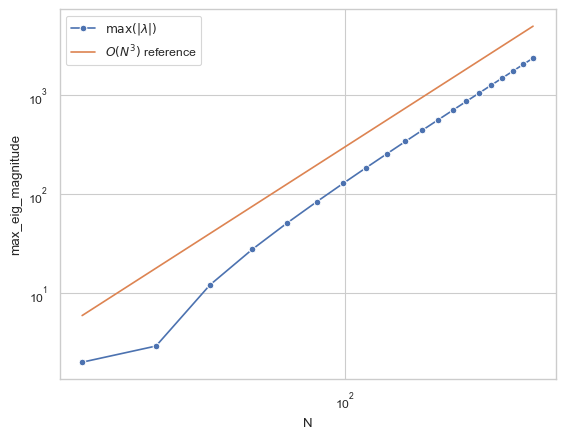

In [31]:
sns.lineplot(
    data=df,
    x="N",
    y="max_eig_magnitude",
    marker="o",
    label="$\\max(|\\lambda|)$",
)
plt.loglog()
C = 3e-4  # Fit such that reference line is above all points
p = 3  # Fit such that slope matches asymptotic behaviour for large N
plt.plot(df["N"], C * df["N"] ** p, label="$O(N^3)$ reference")
# plt.axvline(x=16)
plt.legend()


# Note: Reference should be ABOVE all points for guaranteed stability

[]

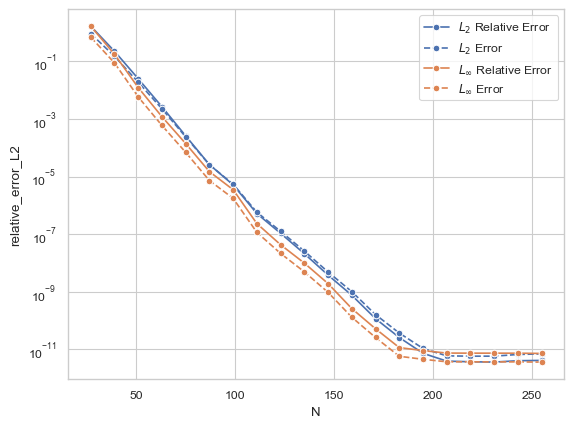

In [18]:
df = pd.DataFrame(data)
plt.figure()
sns.lineplot(
    data=df,
    x="N",
    y="relative_error_L2",
    marker="o",
    ls="-",
    label="$L_2$ Relative Error",
    color="C0",
)
sns.lineplot(
    data=df, x="N", y="error_L2", marker="o", ls="--", label="$L_2$ Error", color="C0"
)

sns.lineplot(
    data=df,
    x="N",
    y="relative_error_L_inf",
    marker="o",
    ls="-",
    label="$L_∞$ Relative Error",
    color="C1",
)
sns.lineplot(
    data=df,
    x="N",
    y="error_L_inf",
    marker="o",
    ls="--",
    label="$L_∞$ Error",
    color="C1",
)
# plt.loglog()
plt.semilogy()

In [19]:
for i, d in enumerate(data):
    print(f"i={i}, N={d.N}, dx={d.dx:.2e}, error_L2={d.error_L2:.2e}")

i=0, N=27, dx=2.14e+00, error_L2=9.13e-01
i=1, N=39, dx=1.50e+00, error_L2=1.49e-01
i=2, N=51, dx=1.15e+00, error_L2=1.88e-02
i=3, N=63, dx=9.38e-01, error_L2=2.23e-03
i=4, N=75, dx=7.89e-01, error_L2=2.37e-04
i=5, N=87, dx=6.82e-01, error_L2=2.56e-05
i=6, N=99, dx=6.00e-01, error_L2=5.41e-06
i=7, N=111, dx=5.36e-01, error_L2=5.78e-07
i=8, N=123, dx=4.84e-01, error_L2=1.25e-07
i=9, N=135, dx=4.41e-01, error_L2=2.59e-08
i=10, N=147, dx=4.05e-01, error_L2=4.87e-09
i=11, N=159, dx=3.75e-01, error_L2=1.01e-09
i=12, N=171, dx=3.49e-01, error_L2=1.61e-10
i=13, N=183, dx=3.26e-01, error_L2=3.70e-11
i=14, N=195, dx=3.06e-01, error_L2=1.08e-11
i=15, N=207, dx=2.88e-01, error_L2=5.97e-12
i=16, N=219, dx=2.73e-01, error_L2=5.82e-12
i=17, N=231, dx=2.59e-01, error_L2=5.83e-12
i=18, N=243, dx=2.46e-01, error_L2=6.67e-12
i=19, N=255, dx=2.34e-01, error_L2=7.00e-12


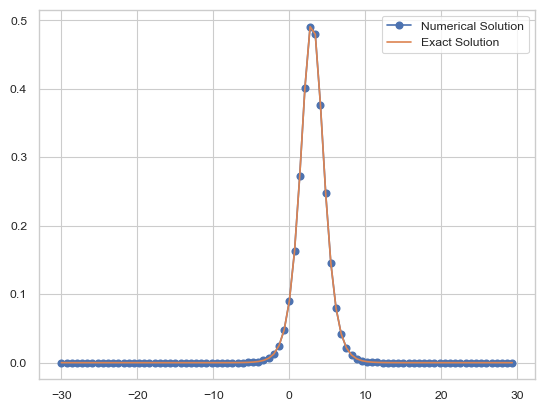

In [20]:
i = 5
d = data[i]
plt.plot(d.x, np.real(d.u_final_numeric), label="Numerical Solution", marker="o")
plt.plot(d.x, np.real(d.u_final_exact), label="Exact Solution")
plt.legend()

# for u in d["u_n"].T:
#     plt.plot(d["x"], np.real(u), color="gray", alpha=0.3)

In [21]:
df_flat = df.explode(
    [
        "t",
        "masses",
        "momenta",
        "energies",
    ]
)
df_flat

,N_grid,N,dx,a,b,L,t_0,t_final,t_max_step,c,...,solve_time_per_step_cpu,solve_nfev,error_L2,relative_error_L2,error_L_inf,relative_error_L_inf,max_eig_magnitude,masses,momenta,energies
0,28,27,2.142857,-30.0,30.0,60.0,0.0,3.0,0.471693,1.0,...,0.000000,68,9.125431e-01,1.659926e+00,6.887513e-01,1.646388e+00,1.993212,2.007361,0.690229,-0.225323
0,28,27,2.142857,-30.0,30.0,60.0,0.0,3.0,0.471693,1.0,...,0.000000,68,9.125431e-01,1.659926e+00,6.887513e-01,1.646388e+00,1.993212,2.007436,0.690276,-0.225302
0,28,27,2.142857,-30.0,30.0,60.0,0.0,3.0,0.471693,1.0,...,0.000000,68,9.125431e-01,1.659926e+00,6.887513e-01,1.646388e+00,1.993212,2.010507,0.695737,-0.222898
0,28,27,2.142857,-30.0,30.0,60.0,0.0,3.0,0.471693,1.0,...,0.000000,68,9.125431e-01,1.659926e+00,6.887513e-01,1.646388e+00,1.993212,2.014591,0.718506,-0.214814
0,28,27,2.142857,-30.0,30.0,60.0,0.0,3.0,0.471693,1.0,...,0.000000,68,9.125431e-01,1.659926e+00,6.887513e-01,1.646388e+00,1.993212,2.008365,0.746547,-0.206951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,256,255,0.234375,-30.0,30.0,60.0,0.0,3.0,0.000560,1.0,...,0.000141,32150,7.004006e-12,4.152865e-12,3.620988e-12,7.245954e-12,2368.116323,2.0,0.666667,-0.2
19,256,255,0.234375,-30.0,30.0,60.0,0.0,3.0,0.000560,1.0,...,0.000141,32150,7.004006e-12,4.152865e-12,3.620988e-12,7.245954e-12,2368.116323,2.0,0.666667,-0.2
19,256,255,0.234375,-30.0,30.0,60.0,0.0,3.0,0.000560,1.0,...,0.000141,32150,7.004006e-12,4.152865e-12,3.620988e-12,7.245954e-12,2368.116323,2.0,0.666667,-0.2
19,256,255,0.234375,-30.0,30.0,60.0,0.0,3.0,0.000560,1.0,...,0.000141,32150,7.004006e-12,4.152865e-12,3.620988e-12,7.245954e-12,2368.116323,2.0,0.666667,-0.2


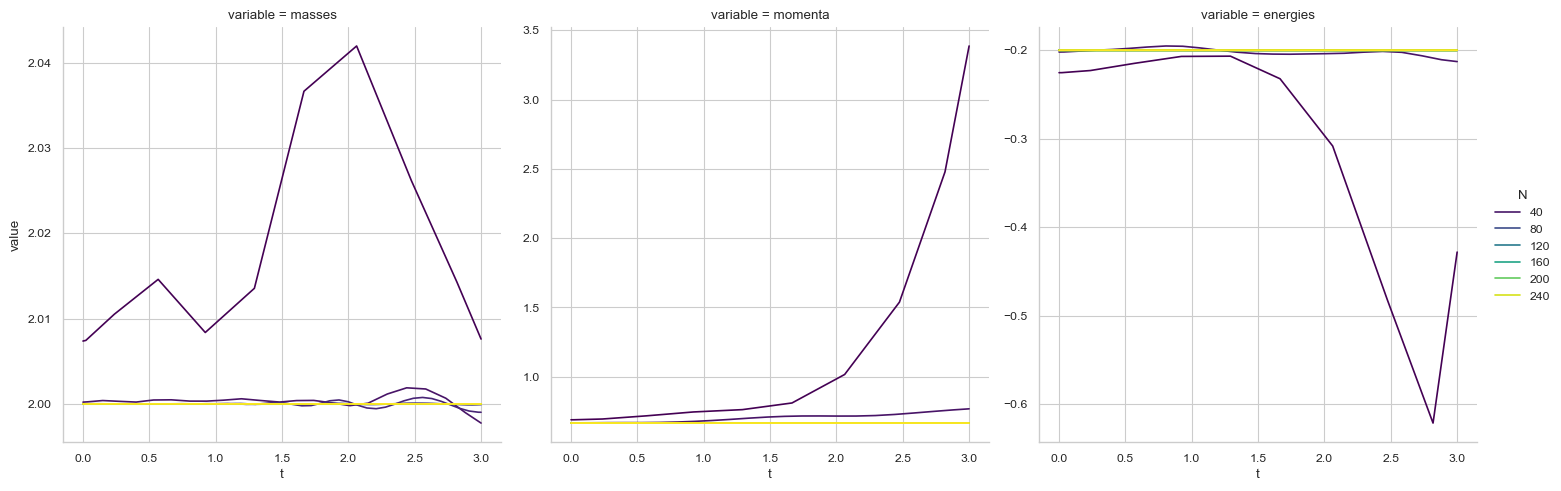

In [22]:
df_flat_melt_conserved = df_flat.melt(
    id_vars=["t", "N"],
    value_vars=[
        "masses",
        "momenta",
        "energies",
    ],
)

sns.relplot(
    data=df_flat_melt_conserved,
    x="t",
    y="value",
    hue="N",
    col="variable",
    kind="line",
    facet_kws={"sharey": False, "sharex": True},
    palette="viridis",
)

# 2.d

In [23]:
# Simulation parameters
t_0 = 0.0
t_final = 3.0

a = -30.0
b = -a

# Problem parameters
cs = [0.25, 0.5, 1.0]
x_0 = 0.0  # Initial position of the soliton


# TODO: Heuristic for minimum discretisation, see FB conversation
N_GRID_MIN = 28
N_GRID_FINE_THRESHOLD = 20
N_GRID_MAX = 128
N_GRID_NUM = 20

# N_grids_fine = np.arange(N_GRID_MIN, N_GRID_FINE_THRESHOLD + 1, dtype=int)
# N_grids_coarse = np.linspace(
#     N_GRID_FINE_THRESHOLD + 1, N_GRID_MAX, num=N_GRID_NUM - len(N_grids_fine), dtype=int
# )
# N_grids = np.concatenate([N_grids_fine, N_grids_coarse])
N_grids = np.linspace(N_GRID_MIN, N_GRID_MAX, num=N_GRID_NUM, dtype=int)


data = []
for N_grid, c in itertools.product(N_grids, cs):
    print(f"Running simulation for N_grid={N_grid}")

    result = single_soliton_simulation(
        a=a, b=b, N_grid=N_grid, c=c, x_0=x_0, t_0=t_0, t_final=t_final
    )
    data.append(result)

data_2d = data.copy()
df = pd.DataFrame([asdict(d) for d in data])

Running simulation for N_grid=28
Running simulation for N_grid=28
Running simulation for N_grid=28
Running simulation for N_grid=33
Running simulation for N_grid=33
Running simulation for N_grid=33
Running simulation for N_grid=38
Running simulation for N_grid=38
Running simulation for N_grid=38
Running simulation for N_grid=43
Running simulation for N_grid=43
Running simulation for N_grid=43
Running simulation for N_grid=49
Running simulation for N_grid=49
Running simulation for N_grid=49
Running simulation for N_grid=54
Running simulation for N_grid=54
Running simulation for N_grid=54
Running simulation for N_grid=59
Running simulation for N_grid=59
Running simulation for N_grid=59
Running simulation for N_grid=64
Running simulation for N_grid=64
Running simulation for N_grid=64
Running simulation for N_grid=70
Running simulation for N_grid=70
Running simulation for N_grid=70
Running simulation for N_grid=75
Running simulation for N_grid=75
Running simulation for N_grid=75
Running si

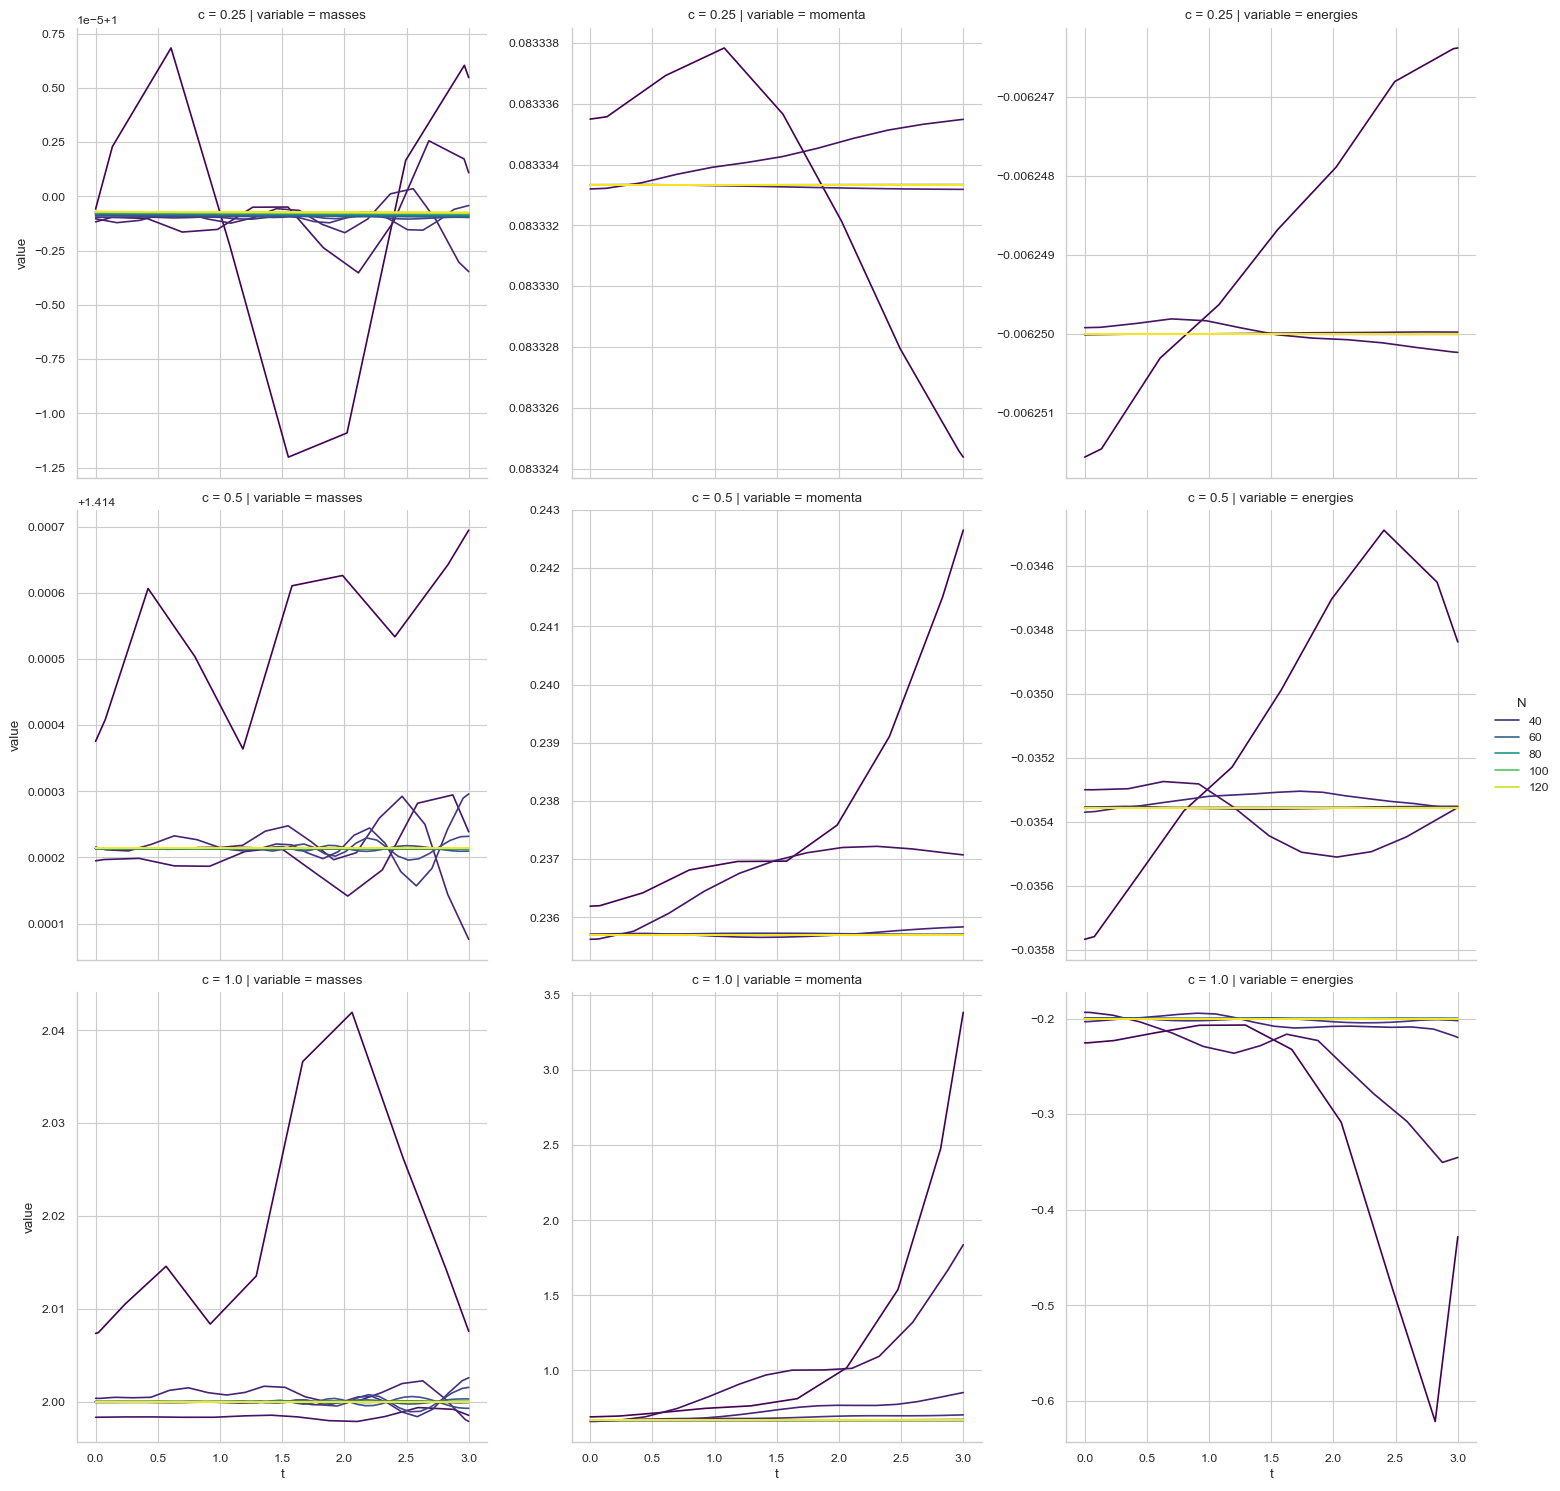

In [24]:
df_flat = df.explode(
    [
        "t",
        "masses",
        "momenta",
        "energies",
    ]
)

df_flat_melt_conserved = df_flat.melt(
    id_vars=["t", "N", "c"],
    value_vars=[
        "masses",
        "momenta",
        "energies",
    ],
)

sns.relplot(
    data=df_flat_melt_conserved,
    x="t",
    y="value",
    hue="N",
    col="variable",
    row="c",
    kind="line",
    facet_kws={"sharey": False, "sharex": True},
    palette="viridis",
)

# 2.e

c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


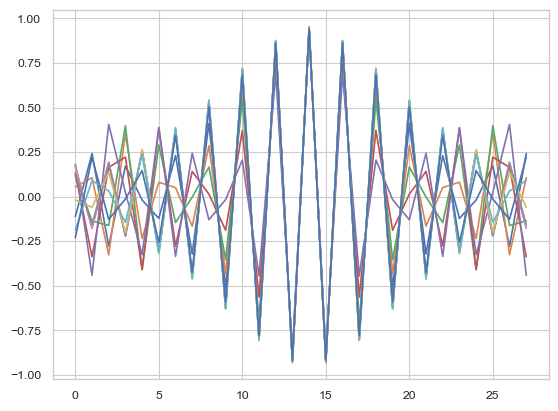

In [25]:
d = data[2]
spectral_coeffs = np.fft.fftshift(np.fft.fft(d.u, axis=0))
plt.plot(spectral_coeffs)

In [26]:
# Repeat 2.d but with 2/3 rule
# Simulation parameters
t_0 = 0.0
t_final = 3.0

a = -30.0
b = -a

# Problem parameters
cs = [0.25, 0.5, 1.0]
x_0 = 0.0  # Initial position of the soliton


# TODO: Heuristic for minimum discretisation, see FB conversation
N_GRID_MIN = 28
N_GRID_FINE_THRESHOLD = 20
N_GRID_MAX = 128
N_GRID_NUM = 20

# N_grids_fine = np.arange(N_GRID_MIN, N_GRID_FINE_THRESHOLD + 1, dtype=int)
# N_grids_coarse = np.linspace(
#     N_GRID_FINE_THRESHOLD + 1, N_GRID_MAX, num=N_GRID_NUM - len(N_grids_fine), dtype=int
# )
# N_grids = np.concatenate([N_grids_fine, N_grids_coarse])
N_grids = np.linspace(N_GRID_MIN, N_GRID_MAX, num=N_GRID_NUM, dtype=int)

data = []
for N_grid, c in itertools.product(N_grids, cs):
    print(f"Running simulation for N_grid={N_grid}")

    result = single_soliton_simulation(
        a=a,
        b=b,
        N_grid=N_grid,
        c=c,
        x_0=x_0,
        t_0=t_0,
        t_final=t_final,
        use_orszag_23_rule=True,
    )
    data.append(result)

data_2e = data.copy()
df = pd.DataFrame([asdict(d) for d in data])

Running simulation for N_grid=28
Running simulation for N_grid=28
Running simulation for N_grid=28
Running simulation for N_grid=33
Running simulation for N_grid=33
Running simulation for N_grid=33
Running simulation for N_grid=38
Running simulation for N_grid=38
Running simulation for N_grid=38
Running simulation for N_grid=43
Running simulation for N_grid=43
Running simulation for N_grid=43
Running simulation for N_grid=49
Running simulation for N_grid=49
Running simulation for N_grid=49
Running simulation for N_grid=54
Running simulation for N_grid=54
Running simulation for N_grid=54
Running simulation for N_grid=59
Running simulation for N_grid=59
Running simulation for N_grid=59
Running simulation for N_grid=64
Running simulation for N_grid=64
Running simulation for N_grid=64
Running simulation for N_grid=70
Running simulation for N_grid=70
Running simulation for N_grid=70
Running simulation for N_grid=75
Running simulation for N_grid=75
Running simulation for N_grid=75
Running si

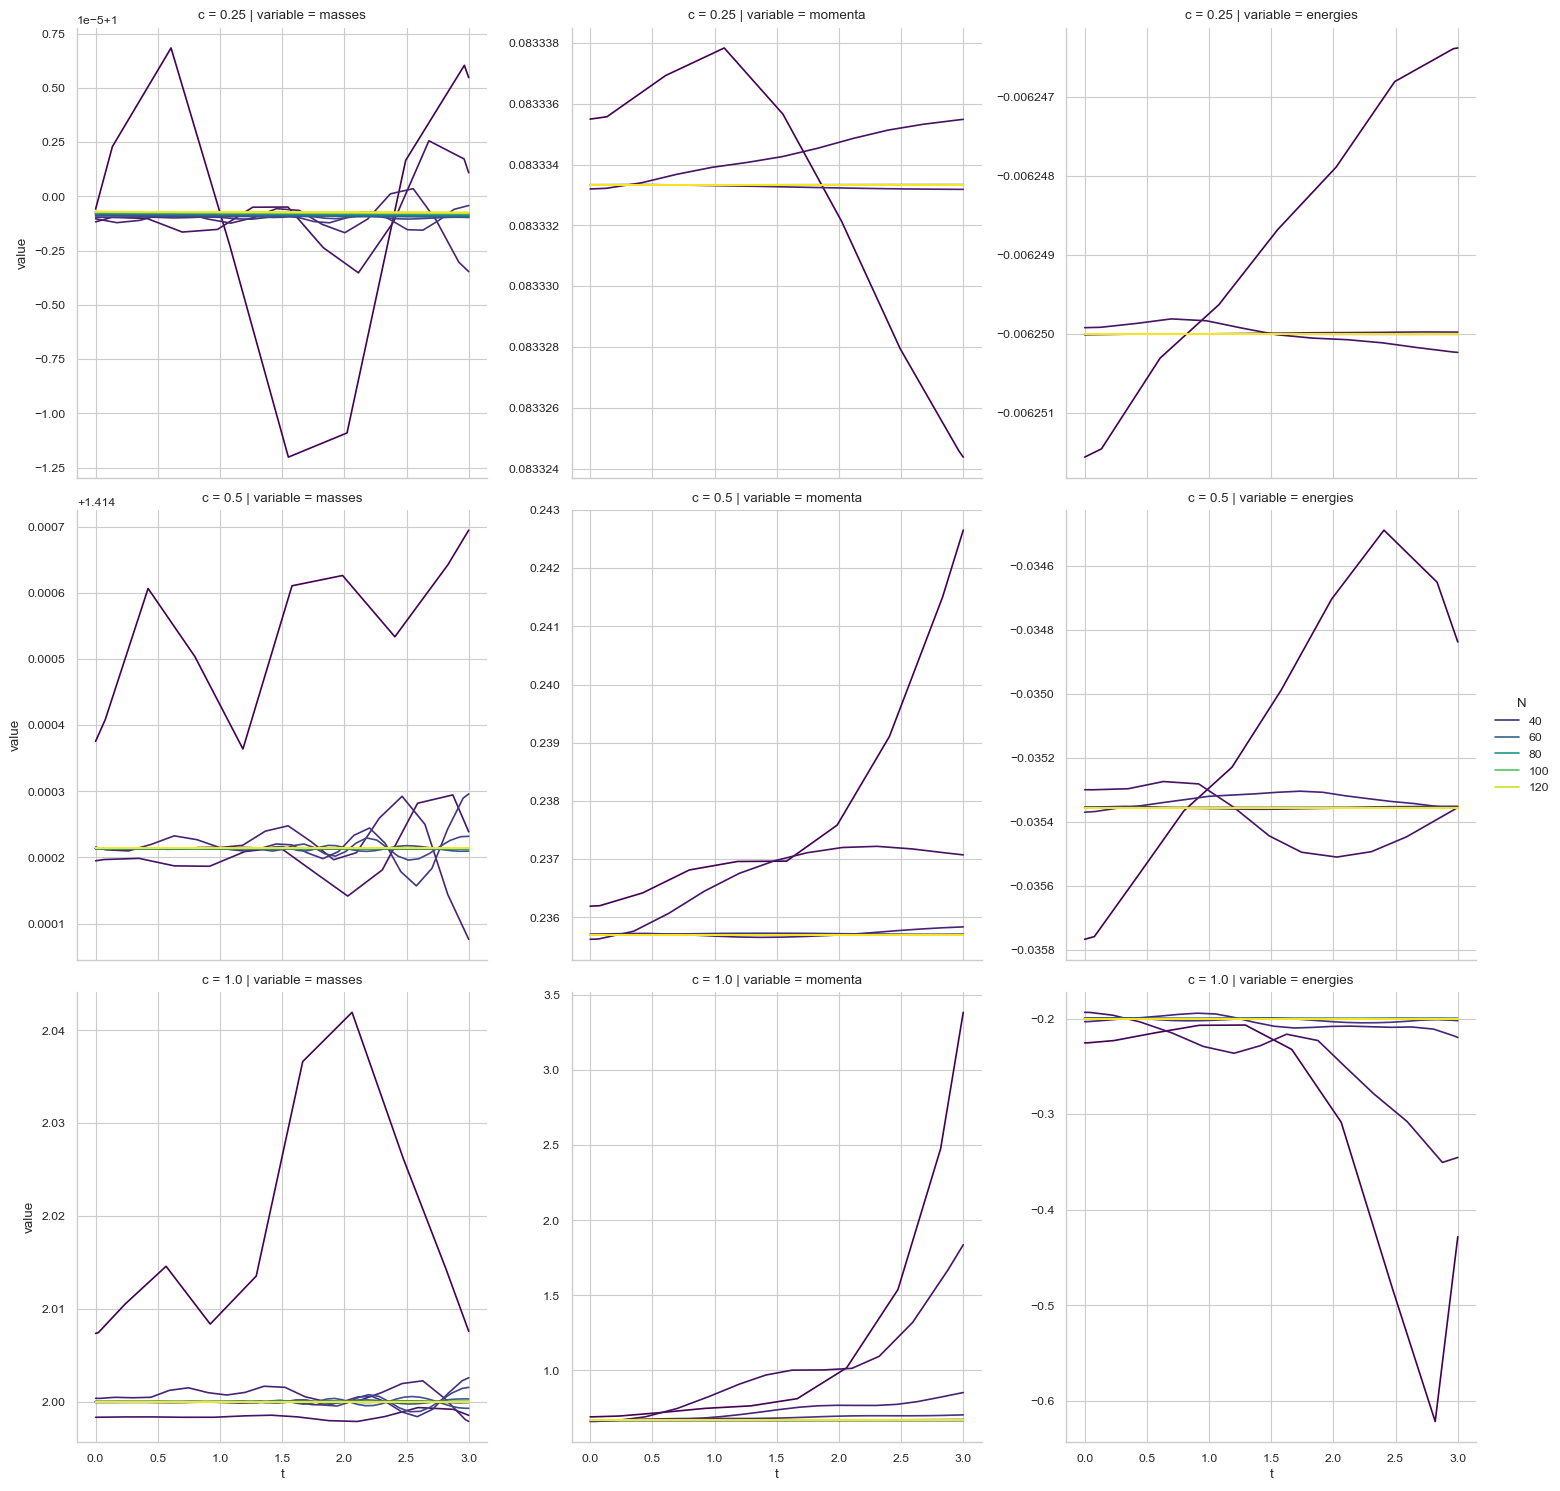

In [18]:
df_flat = df.explode(
    [
        "t",
        "masses",
        "momenta",
        "energies",
    ]
)

df_flat_melt_conserved = df_flat.melt(
    id_vars=["t", "N", "c"],
    value_vars=[
        "masses",
        "momenta",
        "energies",
    ],
)

sns.relplot(
    data=df_flat_melt_conserved,
    x="t",
    y="value",
    hue="N",
    col="variable",
    row="c",
    kind="line",
    facet_kws={"sharey": False, "sharex": True},
    palette="viridis",
)

Note: We find that for decreasing C our wave gets closer to the boundaries, so we need bigger domain again.

Aliasing Discussion:

Non-linear term is multiplication in time domain ⇒ convolution in frequency domain, thus produces new frequencies up to 2K where K is the maximal frequency of $u$..

Since our grid only contains frequencies up to K, the rest are aliased on top of existing frequencies.

We could use Orzag 2/3 rule to try to handle this

Note:
- Initial condition is smooth (C^∞), so they are not likely to cause problems
- Bodged boundary conditions can, but should not readily add new frequencies


[]

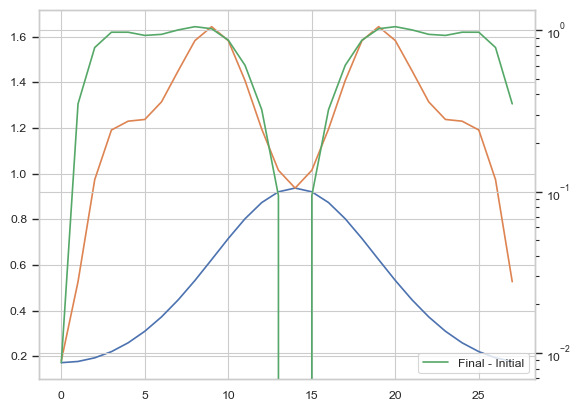

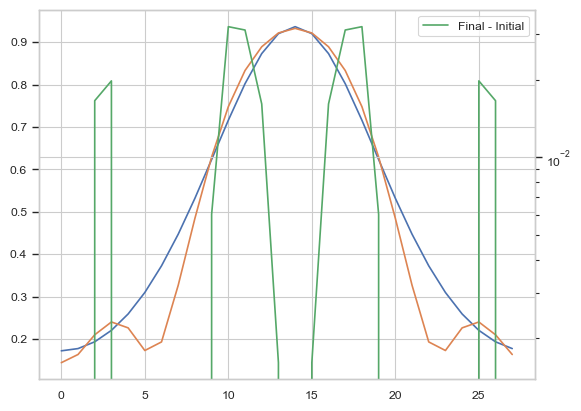

In [27]:
i = 2
d_2d = data_2d[i]
d_2e = data_2e[i]

plt.figure()
d = d_2d
spectral_coeffs_initial = np.fft.fftshift(np.abs(np.fft.fft(d.u[:, 0])))
spectral_coeffs_final = np.fft.fftshift(np.abs(np.fft.fft(d.u[:, -1])))
spectral_coeff_diffs = spectral_coeffs_final - spectral_coeffs_initial
plt.plot(spectral_coeffs_initial, label="Initial")
plt.plot(spectral_coeffs_final, label="Final")
ax2 = plt.twinx()
ax2.plot(spectral_coeff_diffs, label="Final - Initial", color="C2")
plt.legend()
plt.semilogy()

plt.figure()
d = d_2e
spectral_coeffs_initial = np.fft.fftshift(np.abs(np.fft.fft(d.u[:, 0])))
spectral_coeffs_final = np.fft.fftshift(np.abs(np.fft.fft(d.u[:, -1])))
spectral_coeff_diffs = spectral_coeffs_final - spectral_coeffs_initial
plt.plot(spectral_coeffs_initial, label="Initial")
plt.plot(spectral_coeffs_final, label="Final")
ax2 = plt.twinx()
ax2.plot(spectral_coeff_diffs, label="Final - Initial", color="C2")
plt.legend()
plt.semilogy()


# 2f

In [20]:
@dataclass(slots=True, frozen=True)
class DoubleSolitonSimulationResult:
    # Simulation Parameters
    N_grid: int  # Number of grid points
    N: int  # Polynomial degree
    dx: float  # Grid spacing

    a: float  # Domain left boundary
    b: float  # Domain right boundary
    L: float  # Domain length

    t_0: float  # Initial time
    t_final: float  # Final time

    t_max_step: float  # Maximum stable timestep, heuristic estimate

    # Problem Parameters
    c_1: float  # Wave speed
    c_2: float  # Wave speed
    x_0_1: float  # Initial position of the soliton
    x_0_2: float  # Initial position of the soliton

    # Simulation Results
    t: npt.NDArray[np.float64]
    x: npt.NDArray[np.float64]
    u: npt.NDArray[np.float64]
    u_exact: npt.NDArray[np.float64]
    u_final_numeric: npt.NDArray[np.float64]
    u_final_exact: npt.NDArray[np.float64]

    solve_result: Any

    # Errors
    error_L2: float
    relative_error_L2: float
    error_L_inf: float
    relative_error_L_inf: float

    # Heuristics
    max_eig_magnitude: float

    # Conserved quantities
    masses: npt.NDArray[np.float64]
    momenta: npt.NDArray[np.float64]
    energies: npt.NDArray[np.float64]


def double_soliton_simulation(
    a: float,
    b: float,
    N_grid: int,
    c_1: float,
    x_0_1: float,
    c_2: float,
    x_0_2: float,
    t_0: float,
    t_final: float,
    use_orszag_23_rule: bool = False,
    solver_args: dict[str, Any] | None= None,
) -> DoubleSolitonSimulationResult:
    """
    Simulate the KdV equation for double travelling solitons.
    """
    N = N_grid - 1  # Polynomial degree
    L = b - a  # Domain size

    # Basis functions
    basis_func = partial(trigonometric_polynomial_centered, k=0, N=N_grid, L=L)
    basis_func_grad = partial(trigonometric_polynomial_centered, k=1, N=N_grid, L=L)

    # Set up nodes
    # No last point since we impose periodicity through basis functions
    x = np.linspace(a, b, N_grid, endpoint=False)
    dx = x[1] - x[0]

    # Set up differentiation matrix
    V = construct_vandermonde(x, N_grid, basis_func, dtype=np.complex128)
    V_x = construct_vandermonde(x, N_grid, basis_func_grad, dtype=np.complex128)
    D = np.linalg.solve(V.T, V_x.T).T  # D = V_x * V^{-1}, right solve
    D3 = D @ D @ D

    # Set up initial condition
    u_0_1 = travelling_soliton(x, t=t_0, c=c_1, x_0=x_0_1).astype(np.complex128)
    u_0_2 = travelling_soliton(x, t=t_0, c=c_2, x_0=x_0_2).astype(np.complex128)
    u_0 = u_0_1 + u_0_2

    # In order to do heuristic stability analysis we require a matrix representation of our operator,
    # which in turn requires us to linearize the operator, ideally in a conservative manner
    # Conservative comes from the fact that we pick the maximal value of u_0 as a
    # 'worst case' estimate of the non-linear term.
    # u_0_max = np.max(np.abs(u_0))
    u_0_max = c_1 / 2 + c_2 / 2  # Since max is height of both solitons
    L_N_linear = -6 * u_0_max * D - D3

    # Compute eigenvalues for stability analysis
    eigvals_linear_estimate = np.linalg.eigvals(L_N_linear)
    max_eig_magnitude = np.max(np.abs(eigvals_linear_estimate))
    # Using these eigenvalues we can do heuristic from slide 40 of IVP lecture
    # Note that this is somewhat circular here,
    # since I have already done this analysis and implemented the max_timestep function above
    # The derivation of max_timestep(N) is explained below and if any parameters change
    # (discretisation, timestepping algorithm), then the function above should be adjusted
    # by referring to the analysis below this cell

    if use_orszag_23_rule:
        # 2/3 rule is a way to reduce aliasing errors at the cost of resultion
        orszag_23_cutoff_start = int(np.floor(N_grid / 3))
        orszag_23_cutoff_end = int(np.ceil(2 * N_grid / 3))

        # In default fft frequencies are ordered as zero, positive increasing, negative decreasing
        # As such, the high frequency modes are at center of the array
        # See: https://numpy.org/devdocs/reference/routines.fft.html#implementation-details
        orszag_23_filter = np.ones(N_grid, dtype=np.complex128)
        orszag_23_filter[orszag_23_cutoff_start:orszag_23_cutoff_end] = 0

    # Set up differential equation operator
    @numba.jit(nopython=True, parallel=True)
    def eval_timestep(
        t: float, u: npt.NDArray[np.complex128]
    ) -> npt.NDArray[np.complex128]:
        if use_orszag_23_rule:
            # 2/3 rule is a way to reduce aliasing errors at the cost of resolution
            # Note that this part of the function will be JIT compiled,
            # so no need to worry about performance here or precomputation outside the function
            orszag_23_cutoff_start = int(np.floor(N_grid / 3))
            orszag_23_cutoff_end = int(np.ceil(2 * N_grid / 3))

            # In default fft frequencies are ordered as zero, positive increasing, negative decreasing
            # As such, the high frequency modes are at center of the array
            # See: https://numpy.org/devdocs/reference/routines.fft.html#implementation-details
            orszag_23_filter = np.ones(N_grid, dtype=np.complex128)
            orszag_23_filter[orszag_23_cutoff_start:orszag_23_cutoff_end] = 0

            # Apply 23 rule in spectral space
            u_hat = np.fft.fft(u)
            u_hat_filtered = u_hat * orszag_23_filter
            u_filtered = np.fft.ifft(u_hat_filtered)
            u_x = D @ u_filtered
        else:
            u_x = D @ u

        uu_x = u * u_x
        u_xxx = D3 @ u

        return -6 * uu_x - u_xxx

    t_max_step = max_timestep(N)
    solve_result = solve_ivp(
        eval_timestep, (t_0, t_final), u_0, method="RK45", max_step=t_max_step, **(solver_args or {})
    )

    u_numeric = np.real(solve_result.y)
    u_exact = np.zeros_like(u_numeric)
    # We don't actually have a closed form expression for the exact solution at all times
    # due to non-linear interactions
    # for i, t in enumerate(solve_result.t):
    #     u_exact[:, i] = travelling_soliton(x, t, c=c_1, x_0=x_0_1) + travelling_soliton(x, t, c=c_2, x_0=x_0_2)

    # Compute error
    u_final_numeric = u_numeric[:, -1]
    u_final_exact_1 = travelling_soliton(x, t_final, c=c_1, x_0=x_0_1)
    u_final_exact_2 = travelling_soliton(x, t_final, c=c_2, x_0=x_0_2)
    u_final_exact = u_final_exact_1 + u_final_exact_2
    error_L2 = np.linalg.norm(u_final_exact - u_final_numeric, ord=2)
    relative_error_L2 = error_L2 / np.linalg.norm(u_final_exact, ord=2)
    error_L_inf = np.linalg.norm(u_final_exact - u_final_numeric, ord=np.inf)
    relative_error_L_inf = error_L_inf / np.linalg.norm(u_final_exact, ord=np.inf)

    # Compute conserved quantities over time
    masses = np.asarray([mass(u, x) for u in u_numeric.T])
    momenta = np.asarray([momentum(u, x) for u in u_numeric.T])
    energies = np.asarray([energy(u, x, D) for u in u_numeric.T])

    return DoubleSolitonSimulationResult(
        N_grid=N_grid,
        N=N,
        dx=dx,
        a=a,
        b=b,
        L=L,
        t_0=t_0,
        t_final=t_final,
        t_max_step=t_max_step,
        c_1=c_1,
        c_2=c_2,
        x_0_1=x_0_1,
        x_0_2=x_0_2,
        t=solve_result.t,
        x=x,
        u=u_numeric,
        u_exact=u_exact,
        u_final_numeric=u_final_numeric,
        u_final_exact=u_final_exact,
        solve_result=solve_result,
        error_L2=error_L2,
        relative_error_L2=relative_error_L2,
        error_L_inf=error_L_inf,
        relative_error_L_inf=relative_error_L_inf,
        max_eig_magnitude=max_eig_magnitude,
        masses=masses,
        momenta=momenta,
        energies=energies,
    )

L_x = 75.0
t_0 = 0.0
t_final = 120.0
t_eval = np.linspace(t_0, t_final, 60, endpoint=True)
result = double_soliton_simulation(
    a=-L_x,
    b=L_x,
    N_grid=180,
    c_1=0.5,
    c_2=0.25,
    x_0_1=-40.0,
    x_0_2=-15.0,
    t_0=t_0,
    t_final=t_final,
    solver_args={"t_eval": t_eval},
    use_orszag_23_rule=True,
)

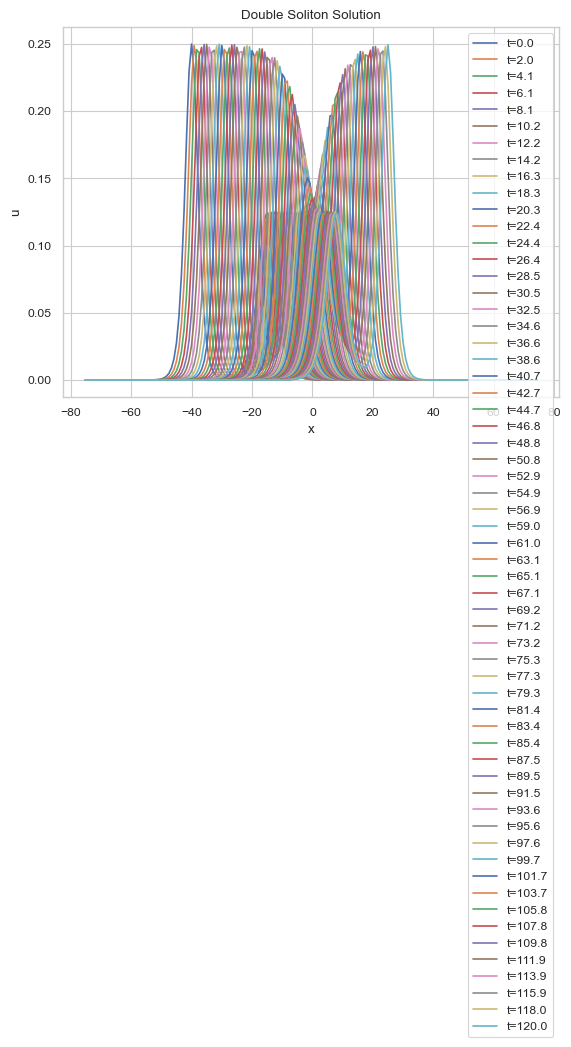

In [21]:
plt.figure()
for t, u in zip(result.t, result.u.T):
    plt.plot(result.x, u, label=f"t={t:.1f}")
plt.xlabel("x")
plt.ylabel("u")
plt.title("Double Soliton Solution")
plt.legend()
plt.show()

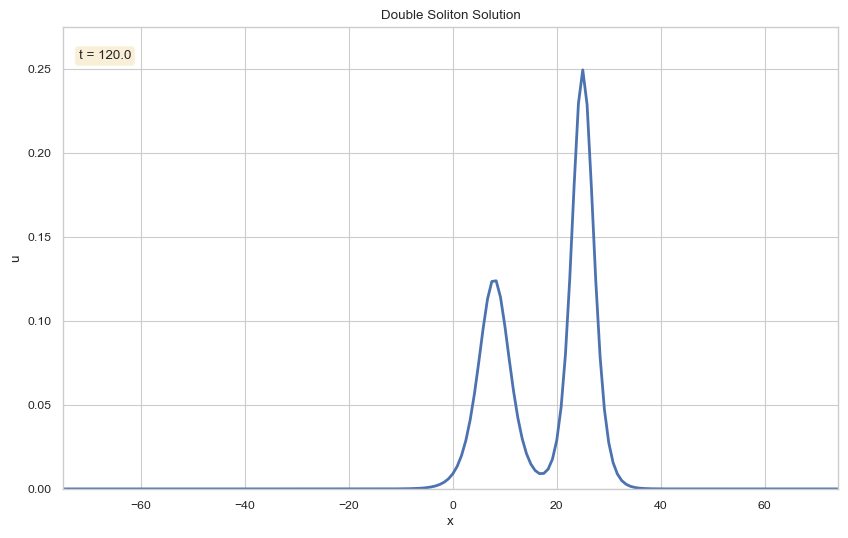

In [22]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 6))

# Set up the plot limits
ax.set_xlim(result.x.min(), result.x.max())
ax.set_ylim(result.u.min() * 1.1, result.u.max() * 1.1)
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.set_title("Double Soliton Solution")

# Initialize line object
(line_numeric,) = ax.plot([], [], '-', linewidth=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                     verticalalignment='top', bbox=dict(boxstyle='round',
                     facecolor='wheat', alpha=0.5))

def init():
    """Initialize animation"""
    line_numeric.set_data([], [])
    time_text.set_text('')
    return line_numeric, time_text

def animate(i):
    """Animation function called for each frame"""
    line_numeric.set_data(result.x, result.u[:, i])
    time_text.set_text(f't = {result.t[i]:.1f}')
    return line_numeric, time_text

# Create animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=len(result.t), interval=200,
                     blit=True, repeat=True)

# Display in notebook
HTML(anim.to_jshtml())

# Optionally save to file
# anim.save('double_soliton.mp4', writer='ffmpeg', fps=5, dpi=150)
# anim.save('double_soliton.gif', writer='pillow', fps=5)

# 2.g - Scalability

Expected scaling:

N^2 because dense matrices times dense vector

<Axes: xlabel='N', ylabel='percent_solve_time_wall'>

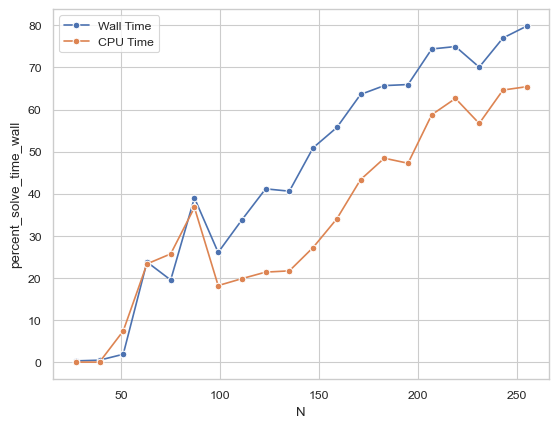

In [23]:
df = pd.DataFrame(asdict(d) for d in data_2c)

df["percent_solve_time_wall"] = df["solve_time_wall"] / df["total_time_wall"] * 100
df["percent_solve_time_cpu"] = df["solve_time_cpu"] / df["total_time_cpu"] * 100
sns.lineplot(
    data=df,
    x="N",
    y="percent_solve_time_wall",
    marker="o",
    label="Wall Time",
)
sns.lineplot(
    data=df,
    x="N",
    y="percent_solve_time_cpu",
    marker="o",
    label="CPU Time",
)

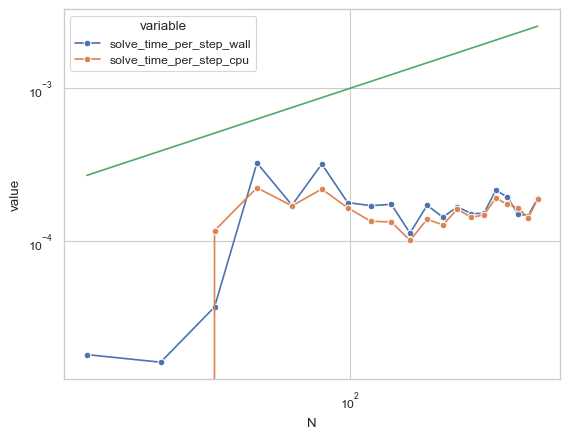

In [24]:
df = pd.DataFrame(asdict(d) for d in data_2c)

dfm = df.melt(id_vars=["N"], value_vars=["solve_time_per_step_wall", "solve_time_per_step_cpu"])
sns.lineplot(
    data=dfm,
    x="N",
    y="value",
    hue="variable",
    marker="o",
)
plt.loglog()
plt.plot(df["N"], 1e-5 * df["N"] ** 1, label="$O(N^2)$ reference")

Not really sure what he wants here. It would seem to me to make most sense to evaluate the spatial discretisation directly or at least investigate performance in smaller parts of the code, but it seems like he wants us to do the whole thing.

Probably need to investigate a bit more as to why it is this good?

It might be that solve_ivp has large overhead between timesteps for smaller N?